In [1]:
cd ..

/Users/hyunminhong/Kalman-Heston-Filter


In [2]:
from src.Utility import Utility, MeasurementType
from src.KalmanFilterSV import HestonKalmanFilter
from src.KalmanFilterCorr import HestonKalmanFilterCorr
from src.ParticleFilter import PFHeston
from src.Heston import *
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [3]:
# Set initial conditions and simulation parameters
S0 = 100
V0 = 0.04
params = {
    'mu': 0.05,
    'rho': 0,
    'kappa': 5.0,
    'theta': 0.04,
    'xi': 0.35
}
std_asy = np.sqrt(params['theta'] * params['xi']**2 / (2 * params['kappa']))
feller_cond = 2 * params['kappa'] * params['theta'] / params['xi']**2
print(round(feller_cond, 2))
assert feller_cond > 1, "Feller condition is violated!"

Hest = Heston(**params)
time_daily, S_daily, daily_returns, daily_true_V, daily_RV = Hest.path_simulation(
    S0, V0, T_years=10, trading_days=252, intraday_intervals=39, seed=40
)
R_daily = daily_returns.copy()

3.27


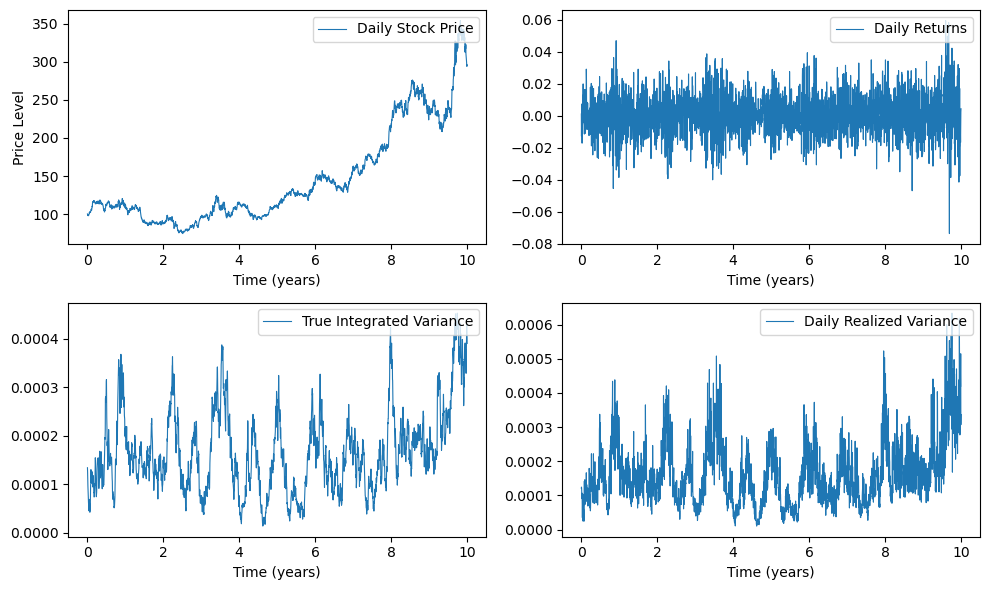

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Subplot for BOTH measurements
axes[0,0].plot(time_daily, S_daily, label="Daily Stock Price", lw=0.8)
axes[0,0].set_xlabel("Time (years)")
axes[0,0].set_ylabel("Price Level")
axes[0,0].legend(loc="upper right")

# Subplot for RETURNS measurement
axes[0,1].plot(time_daily, daily_returns, label="Daily Returns", lw=0.8)
axes[0,1].set_xlabel("Time (years)")
axes[0,1].legend(loc="upper right")

# Subplot for RV measurement
axes[1,0].plot(time_daily, daily_true_V, label="True Integrated Variance", lw=0.8)
axes[1,0].set_xlabel("Time (years)")
axes[1,0].legend(loc="upper right")

# Subplot for RV measurement
axes[1,1].plot(time_daily, daily_RV, label="Daily Realized Variance", lw=0.8)
axes[1,1].set_xlabel("Time (years)")
axes[1,1].legend(loc="upper right")

plt.tight_layout()
plt.show()

In [5]:
burnin = 252
dt = 1  # Daily

split_index = 6 * 252 

# TRAINING SET 
train_returns = daily_returns[:split_index]
train_RV = daily_RV[:split_index]

# TEST SET 
test_returns = daily_returns[split_index:]
test_RV = daily_RV[split_index:]

### Both

In [6]:
# Fit the model using training data
hkf_both = HestonKalmanFilter(measurement_type=MeasurementType.BOTH, dt=dt, V0=0.01, P0=0.1)
hkf_both.set_data(returns=train_returns, rv=train_RV)
initial_params_both = np.array([0.001, 0.001, 0.001, 0.001, 0.001]) 
# 1e-02, 1e-04, 8e-04, 4e-04, 3.16325904e-06

fit_results_both = hkf_both.fit(initial_params=initial_params_both, burnin=burnin)
params_opt_both = fit_results_both['params']
print("Optimized parameters (BOTH):", params_opt_both)

train_result_both = hkf_both.filter(params_opt_both)
last_V_train = train_result_both['V_filt'][-1]
last_P_train = train_result_both['P_filt'][-1]

hkf_both_test = HestonKalmanFilter(measurement_type=MeasurementType.BOTH, dt=dt, V0=last_V_train, P0=last_P_train)
V_filt_both_test = hkf_both_test.filter(params=params_opt_both, returns=test_returns, rv=test_RV)['V_filt']

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.40471D+04    |proj g|=  2.01000D-01

At iterate    1    f= -1.40486D+04    |proj g|=  2.00734D-01

At iterate    2    f= -1.40573D+04    |proj g|=  2.46033D+04

At iterate    3    f= -1.40599D+04    |proj g|=  2.13762D+03

At iterate    4    f= -1.40612D+04    |proj g|=  2.36323D+03

At iterate    5    f= -1.40615D+04    |proj g|=  2.33452D+03

At iterate    6    f= -1.40617D+04    |proj g|=  3.84723D+03

At iterate    7    f= -1.40620D+04    |proj g|=  3.18348D+03

At iterate    8    f= -1.40621D+04    |proj g|=  5.16505D+02

At iterate    9    f= -1.40621D+04    |proj g|=  3.62509D+02

At iterate   10    f= -1.40621D+04    |proj g|=  2.25387D+02

At iterate   11    f= -1.40624D+04    |proj g|=  1.36294D+03

At iterate   12    f= -1.40624D+04    |proj g|=  2.39858D+03

At iterate   13    f= -1.4

### Both - Corr

In [7]:
hkf_both_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.BOTH, dt=dt, V0=0.01, P0=0.1)
hkf_both_corr.set_data(returns=train_returns, rv=train_RV)
initial_params_both_corr = np.array([0.015, 0.0001, 0.001, 0.001, 0.001, -0.1])
# initial_params_both_corr = np.array([0.1, 0.01, 0.01, 0.001, 0.001, -0.1])

fit_results_both_corr = hkf_both_corr.fit(initial_params=initial_params_both_corr, burnin=burnin)
params_opt_both_corr = fit_results_both_corr['params']
print("Optimized parameters (BOTH):", params_opt_both_corr)

train_result_both_corr = hkf_both_corr.filter(params_opt_both_corr)
last_V_train_corr = train_result_both_corr['V_filt'][-1]
last_P_train_corr = train_result_both_corr['P_filt'][-1]

hkf_both_test_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.BOTH, dt=dt, V0=last_V_train_corr, P0=last_P_train_corr)
test_result_both_corr = hkf_both_test_corr.filter(params=params_opt_both_corr, returns=test_returns, rv=test_RV)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.40555D+04    |proj g|=  7.48844D+04

At iterate    1    f= -1.40556D+04    |proj g|=  8.90000D-01

At iterate    2    f= -1.40566D+04    |proj g|=  8.90000D-01

At iterate    3    f= -1.40568D+04    |proj g|=  7.77322D+03

At iterate    4    f= -1.40576D+04    |proj g|=  4.04292D+04

At iterate    5    f= -1.40587D+04    |proj g|=  5.98461D+04

At iterate    6    f= -1.40600D+04    |proj g|=  3.66534D+04

At iterate    7    f= -1.40609D+04    |proj g|=  1.67521D+04

At iterate    8    f= -1.40619D+04    |proj g|=  1.43255D+04

At iterate    9    f= -1.40629D+04    |proj g|=  9.07063D+03

At iterate   10    f= -1.40639D+04    |proj g|=  2.10942D+03

At iterate   11    f= -1.40643D+04    |proj g|=  1.99983D+00

At iterate   12    f= -1.40644D+04    |proj g|=  6.01960D+02

At iterate   13    f= -1.4

### Return

In [8]:
# Fit the model using training data
hkf_returns = HestonKalmanFilter(measurement_type=MeasurementType.RETURNS, dt=dt, V0=0.01, P0=0.1)
hkf_returns.set_data(returns=train_returns)
initial_params_returns = np.array([0.001, 0.001, 0.001, 0.001])

fit_results_returns = hkf_returns.fit(initial_params=initial_params_returns, burnin=burnin)
params_opt_returns = fit_results_returns['params']
print("Optimized parameters (RETURNS):", params_opt_returns)

train_result_returns = hkf_returns.filter(params_opt_returns)
last_V_returns = train_result_returns['V_filt'][-1]
last_P_returns = train_result_returns['P_filt'][-1]

hkf_returns_test = HestonKalmanFilter(measurement_type=MeasurementType.RETURNS, dt=dt, V0=last_V_returns, P0=last_P_returns)
V_filt_returns_test = hkf_returns_test.filter(params=params_opt_returns, returns=test_returns)['V_filt']

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.55243D+03    |proj g|=  2.68353D+05

At iterate    1    f= -3.09330D+03    |proj g|=  7.02175D-01

At iterate    2    f= -3.65136D+03    |proj g|=  5.87461D+00

At iterate    3    f= -3.65516D+03    |proj g|=  1.56840D+01

At iterate    4    f= -3.65815D+03    |proj g|=  1.48467D+04

At iterate    5    f= -3.66429D+03    |proj g|=  1.78859D+01

At iterate    6    f= -3.66643D+03    |proj g|=  1.40888D+05

At iterate    7    f= -3.67384D+03    |proj g|=  3.12355D+05

At iterate    8    f= -3.68790D+03    |proj g|=  5.94869D+05

At iterate    9    f= -3.70257D+03    |proj g|=  5.06188D+05

At iterate   10    f= -3.71621D+03    |proj g|=  3.08661D+05

At iterate   11    f= -3.72286D+03    |proj g|=  7.80028D+04

At iterate   12    f= -3.72596D+03    |proj g|=  1.48711D+05

At iterate   13    f= -3.7

### Return - Corr

In [9]:
# Fit the model using training data
hkf_returns_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.RETURNS, dt=dt, V0=0.02, P0=0.1)
hkf_returns_corr.set_data(returns=train_returns)
initial_params_returns_corr = np.array([0.002, 0.0001, 0.007, 0.002, 0])

fit_results_returns_corr = hkf_returns_corr.fit(initial_params=initial_params_returns_corr, burnin=burnin)
params_opt_returns_corr = fit_results_returns_corr['params']
print("Optimized parameters (RETURNS):", params_opt_returns_corr)

train_result_returns_corr = hkf_returns_corr.filter(params_opt_returns_corr)
last_V_returns_corr = train_result_returns_corr['V_filt'][-1]
last_P_returns_corr = train_result_returns_corr['P_filt'][-1]

hkf_returns_test_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.RETURNS, dt=dt, V0=last_V_returns_corr, P0=last_P_returns_corr)
test_result_returns_corr = hkf_returns_test_corr.filter(params=params_opt_returns_corr, returns=test_returns)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.65519D+03    |proj g|=  1.81932D+05

At iterate    1    f= -3.63270D+03    |proj g|=  3.82576D+06

At iterate    2    f= -3.69929D+03    |proj g|=  9.89995D-01

At iterate    3    f= -3.70838D+03    |proj g|=  9.89995D-01

At iterate    4    f= -3.71582D+03    |proj g|=  9.89995D-01

At iterate    5    f= -3.71633D+03    |proj g|=  7.40694D+04

At iterate    6    f= -3.71644D+03    |proj g|=  7.97627D-01

At iterate    7    f= -3.71647D+03    |proj g|=  1.44834D+04

At iterate    8    f= -3.71658D+03    |proj g|=  4.60680D+04

At iterate    9    f= -3.71698D+03    |proj g|=  1.18932D+05

At iterate   10    f= -3.71784D+03    |proj g|=  2.15625D+05

At iterate   11    f= -3.71990D+03    |proj g|=  3.44175D+05

At iterate   12    f= -3.72335D+03    |proj g|=  3.99470D+05

At iterate   13    f= -3.7

### RV

In [10]:
hkf_rv = HestonKalmanFilter(measurement_type=MeasurementType.RV, dt=dt, V0=0.01, P0=0.1)
hkf_rv.set_data(rv=train_RV)
initial_params_rv = np.array([0.001, 0.001, 0.001, 0.001])

fit_results_rv = hkf_rv.fit(initial_params=initial_params_rv, burnin=burnin)
params_opt_rv = fit_results_rv['params']
print("Optimized parameters (RV):", params_opt_rv)

train_result_rv = hkf_rv.filter(params_opt_rv)
last_V_rv = train_result_rv['V_filt'][-1]
last_P_rv = train_result_rv['P_filt'][-1]

hkf_rv_test = HestonKalmanFilter(measurement_type=MeasurementType.RV, dt=dt, V0=last_V_rv, P0=last_P_rv)
test_result_rv = hkf_rv_test.filter(params=params_opt_rv, rv=test_RV)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.52970D+03    |proj g|=  1.64535D+06

At iterate    1    f= -9.95049D+03    |proj g|=  4.10058D+02

At iterate    2    f= -1.09509D+04    |proj g|=  3.43343D-03
  Positive dir derivative in projection 
  Using the backtracking step 

At iterate    3    f= -1.10131D+04    |proj g|=  1.21870D+03

At iterate    4    f= -1.10132D+04    |proj g|=  2.69633D-03

At iterate    5    f= -1.10165D+04    |proj g|=  1.99736D+00

At iterate    6    f= -1.10176D+04    |proj g|=  8.93311D+03

At iterate    7    f= -1.10181D+04    |proj g|=  2.75053D-03

At iterate    8    f= -1.10183D+04    |proj g|=  1.99725D+00

At iterate    9    f= -1.10187D+04    |proj g|=  1.99725D+00

At iterate   10    f= -1.10188D+04    |proj g|=  1.73915D+02

At iterate   11    f= -1.10188D+04    |proj g|=  1.93884D+02

At iterate   12 

### PF

In [11]:
pf_heston_train = PFHeston(train_returns, N=5000, dt=1/252, is_log=True)

param_bounds_train = [
    (-0.1, 0.1),    # mu
    (1, 5),        # kappa
    (0.02, 0.03),    # theta
    (0.1, 0.3),    # xi
    (-0.9, 0),        # rho
    V0              # v0
]

_, estimated_param = pf_heston_train.filter(param_bounds_train, predict_obs=False)
param_bounds = list(zip(estimated_param[:,-1] - 1e-3, estimated_param[:,-1] + 1e-3))

resampling since: 1731.5228853446265
resampling since: 2889.0580579114257
resampling since: 2524.156846255957
resampling since: 206.77575207802596
resampling since: 484.9377395637187
resampling since: 1602.5081794705104
resampling since: 741.3223260140331
resampling since: 810.8435375966458
resampling since: 1512.6973140643604
resampling since: 149.56553260590334
resampling since: 2139.3885660525807
resampling since: 2530.9447584084755
resampling since: 515.1406595810879
resampling since: 3348.2357222016312
resampling since: 922.7504624463726
resampling since: 642.9415035250832
resampling since: 1601.726587672378
resampling since: 3201.9649125695255
resampling since: 2594.3779728848367
resampling since: 3023.5727941208947
resampling since: 781.25127274739
resampling since: 2729.086166686676
resampling since: 3003.190720411913
resampling since: 1886.1541633610527
resampling since: 293.54331198744364
resampling since: 578.2947116794088
resampling since: 6.634510158685222
resampling since

In [12]:
pf_heston_test = PFHeston(test_returns, N=5000, dt=1/252, is_log=True)

V_pf_train, _ = pf_heston_train.filter([*param_bounds, V0], predict_obs=False)
V_pf_test, _ = pf_heston_test.filter([*param_bounds, V_pf_train[-1]], predict_obs=False)

resampling since: 3416.1551886440398
resampling since: 2810.003842334626
resampling since: 3291.859669841458
resampling since: 3249.748721348295
resampling since: 3351.06500928757
resampling since: 3240.104785004685
resampling since: 3397.4479797852223
resampling since: 3337.360561367883
resampling since: 1660.2393042659526
resampling since: 3399.798891767143
resampling since: 3257.002605458133
resampling since: 3450.979834926919
resampling since: 3323.2042564545204
resampling since: 3379.3540249039265
resampling since: 2647.865282616901
resampling since: 3478.4935581421732
resampling since: 2610.931178586461
resampling since: 2803.371544688589
resampling since: 3178.280198439232
resampling since: 2990.3884130821534
resampling since: 1260.983108405565
resampling since: 2394.502518847429
resampling since: 3201.9808649726833
resampling since: 2816.3001491168643
resampling since: 3422.2534631970725
resampling since: 3470.4958754771337
resampling since: 3112.938563841422
resampling since: 

In [13]:
V_pf_train_daily = V_pf_train / 400
V_pf_test_daily = V_pf_test / 400

## Plot

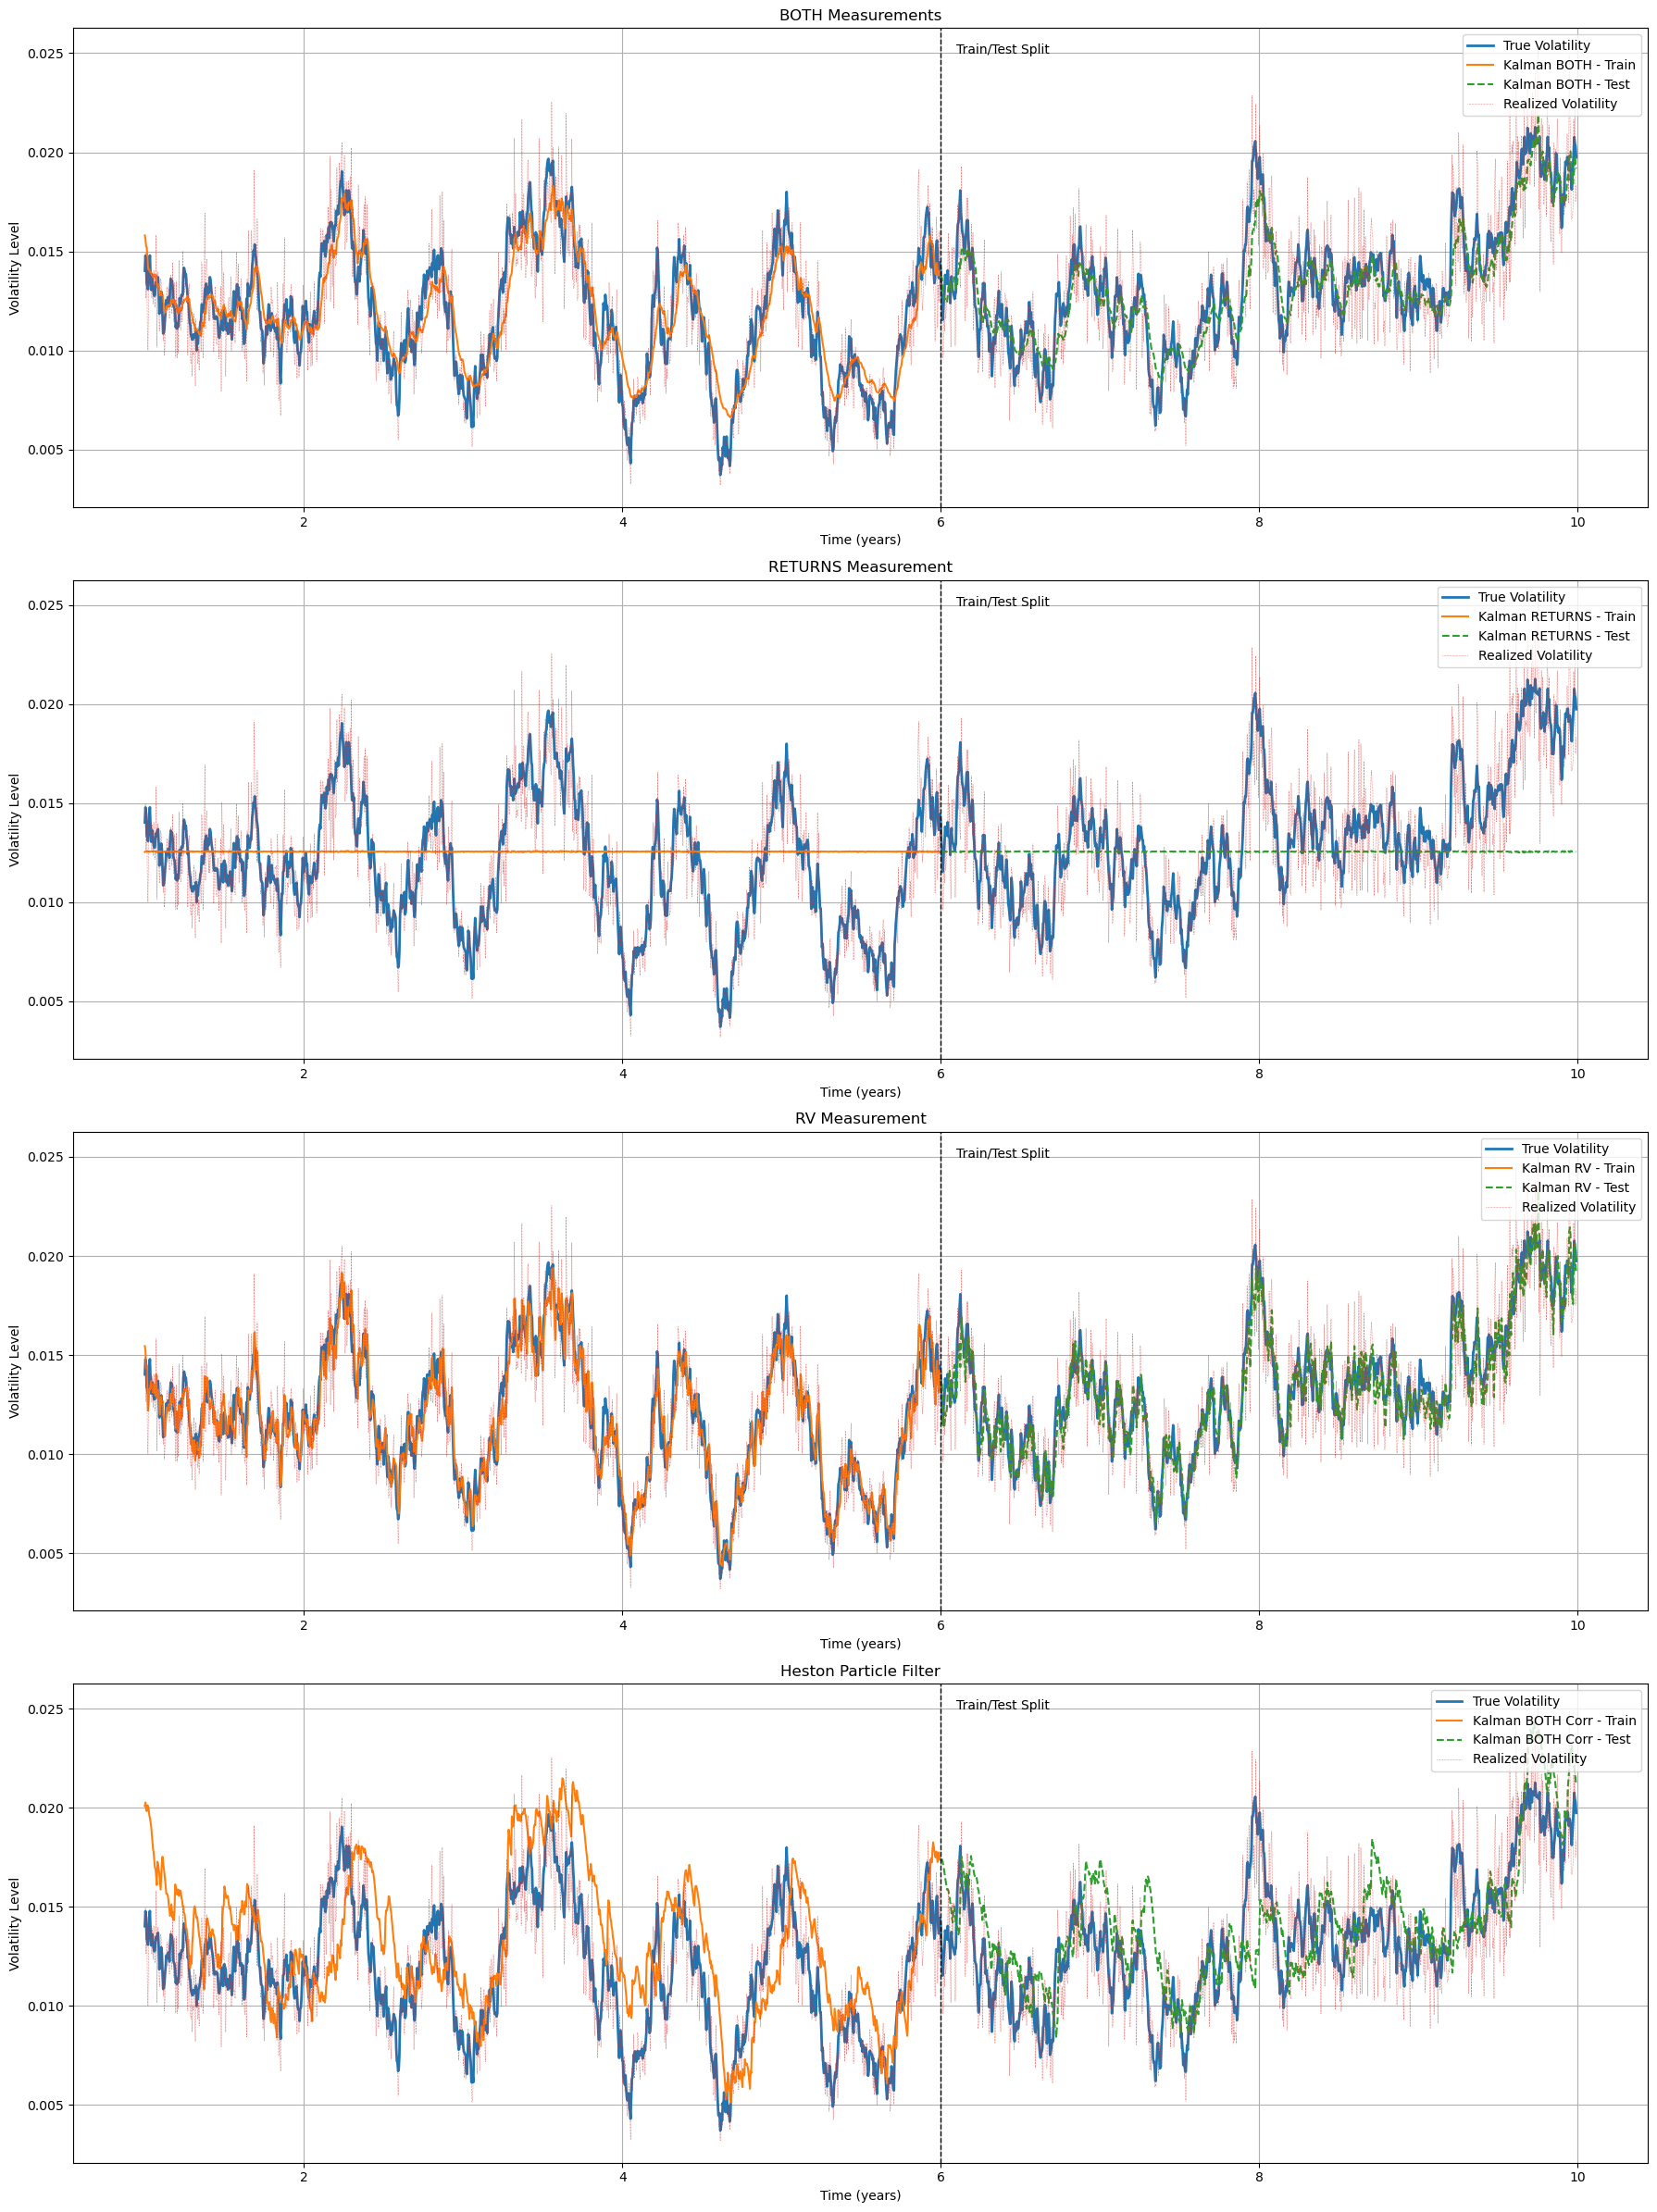

In [18]:
v_item = 'V_filt'

titles_all = ["BOTH Measurements", "RETURNS Measurement", "RV Measurement", "Heston Particle Filter"]
labels_all = ["Kalman BOTH", "Kalman RETURNS", "Kalman RV", "Kalman BOTH Corr", "Kalman RETURNS Corr", "PF Heston"]
train_all = [train_result_both_corr[v_item], train_result_returns_corr[v_item], train_result_rv[v_item], V_pf_train_daily]
test_all = [test_result_both_corr[v_item], test_result_returns_corr[v_item], test_result_rv[v_item], V_pf_test_daily]

Utility.plot_all_filters(
    titles=titles_all,
    labels=labels_all,
    train_filtered_list=train_all,
    test_filtered_list=test_all,
    daily_true_V=daily_true_V,
    daily_RV=daily_RV,
    daily_returns=daily_returns,
    split_index=split_index,
    burnin=252, 
    save_path=r"./output/noLeverage.png"
)

In [15]:
def qlike_loss(true_var, pred_var):
    y = np.asarray(true_var)
    h = np.asarray(pred_var)
    
    eps = np.finfo(float).eps
    ratio = y / (h + eps)
    return np.mean(ratio - np.log(ratio) - 1)

model_names = ['both_corr', 'returns_corr', 'rv', 'pf']
true_variances   = daily_true_V[split_index:]
true_volatilities = np.sqrt(true_variances)

mae_scores   = {}
rmse_scores  = {}
mape_scores  = {}
qlike_scores = {}

for name, pred_var in zip(model_names, test_all):
    pred_vol = np.sqrt(pred_var)
    
    mae_scores[name]   = mean_absolute_error(true_volatilities, pred_vol)
    rmse_scores[name]  = np.sqrt(mean_squared_error(true_volatilities, pred_vol))
    mape_scores[name]  = mean_absolute_percentage_error(true_volatilities, pred_vol) * 100
    qlike_scores[name] = qlike_loss(true_variances, pred_var)

print("Results including QLIKE:")
for name in model_names:
    print(f"{name:12s} MAE: {mae_scores[name]:.6f}, "
          f"RMSE: {rmse_scores[name]:.6f}, "
          f"MAPE: {mape_scores[name]:.3f}%, "
          f"QLIKE: {qlike_scores[name]:.6f}")


Results including QLIKE:
both_corr    MAE: 0.000948, RMSE: 0.001199, MAPE: 7.450%, QLIKE: 0.018275
returns_corr MAE: 0.002448, RMSE: 0.003229, MAPE: 18.175%, QLIKE: 0.124584
rv           MAE: 0.000710, RMSE: 0.000906, MAPE: 5.328%, QLIKE: 0.009673
pf           MAE: 0.001953, RMSE: 0.002501, MAPE: 15.526%, QLIKE: 0.067043


In [17]:
import pandas as pd
data = {}

data['both_corr'] = dict(zip(
    ['kappa', 'theta', 'xi', 'mu', 'sigma', 'rho'],
    params_opt_both_corr
))

data['returns_corr'] = dict(zip(
    ['kappa', 'theta', 'xi', 'mu', 'rho'],
    params_opt_returns_corr
))
data['returns_corr']['sigma'] = np.nan

data['rv'] = dict(zip(
    ['kappa', 'theta', 'xi', 'sigma'],
    params_opt_rv
))
data['rv']['mu']  = np.nan
data['rv']['rho'] = np.nan

pf_vals = estimated_param[:, -1]
data['pf'] = {
    'kappa': pf_vals[1],
    'theta': pf_vals[2],
    'xi':    pf_vals[3],
    'mu':    pf_vals[0],
    'rho':   pf_vals[4],
    'sigma': np.nan
}

cols = ['kappa', 'theta', 'xi', 'mu', 'sigma', 'rho']
df_params = pd.DataFrame.from_dict(data, orient='index')[cols]

df_params.T

,both_corr,returns_corr,rv,pf
kappa,0.010272,1.001120,0.009296,1.033868
theta,0.000142,0.000158,0.000140,0.027460
xi,0.000965,0.006999,0.001222,0.292769
mu,0.000370,0.000303,NaN,-0.019292
sigma,0.000229,NaN,0.002763,NaN
rho,-0.100317,0.000006,NaN,-0.270605


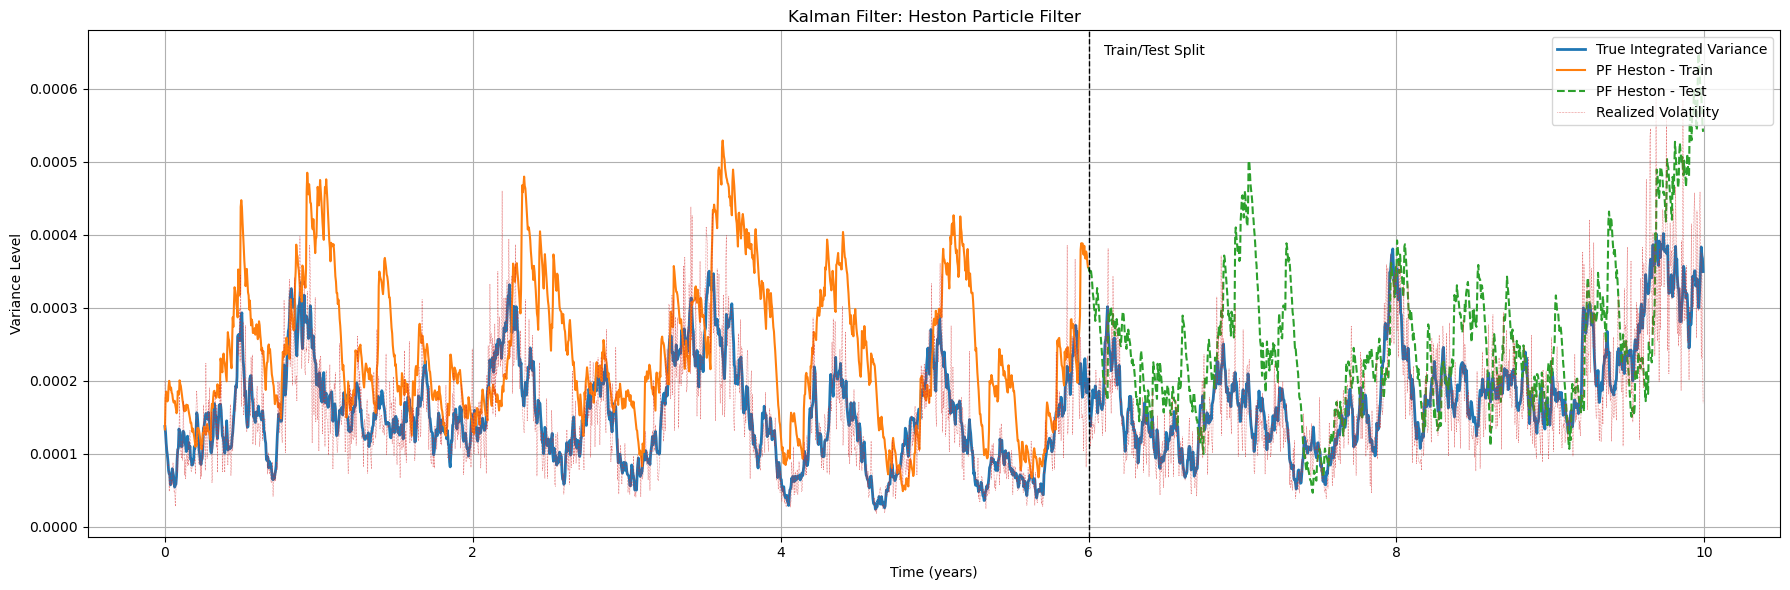

In-Sample RMSE (Heston Particle Filter): 0.000122
Out-of-Sample RMSE (Heston Particle Filter): 0.000110


(0.00012217167608488048, 0.00011009081122822449)

In [27]:
Utility.plot_filter_result(
    plot_index=5,
    titles=titles_all,
    labels=labels_all,
    train_filtered_list=train_all,
    test_filtered_list=test_all,
    daily_true_V=daily_true_V,
    daily_RV=daily_RV,
    daily_returns=daily_returns,
    split_index=split_index,
    burnin=0
)